In [5]:
# ------------------
# Import libraries
# ------------------

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('nbagg')

In [21]:
# -------------------------
# Parameters configuration
# -------------------------

# Spatial
nx = 2000        # Number of grid in x-direction
nptx = nx + 1     # Number of grid points in x-direction
xmax = 500      # Physical domain (m)
dx = xmax / nx    # Grid point distance 

# Temporal
nt = 2501         # Maximum number of time steps
dt = 0.0005    # Time step

# Medium
c0 = 334.         # Wave speed (m/s)
rho = 1000.       # Density of medium (kg/m3)
kapa = rho * c0 ** 2 # Bulk modulus

# Source
sx = int(nx/2)    # Source location in grid point
f0 = 15.          # Dominant frequency of source (Hz)
t0 = 4. / f0      # Time shift of source

In [22]:
# ----------------
# CFL criterion
# ----------------

cfl = c0 * dt / dx
print("CFL number is %.3f" % cfl)

CFL number is 0.668


In [36]:
# ---------------------------
# Source time function
# ---------------------------

time = np.arange(nt + 1) * dt
# 1st derivative of gaussian function
src = -8. * (time - t0) * f0 * (np.exp(-1.0 * (4*f0) ** 2 * (time - t0) ** 2))

<IPython.core.display.Javascript object>


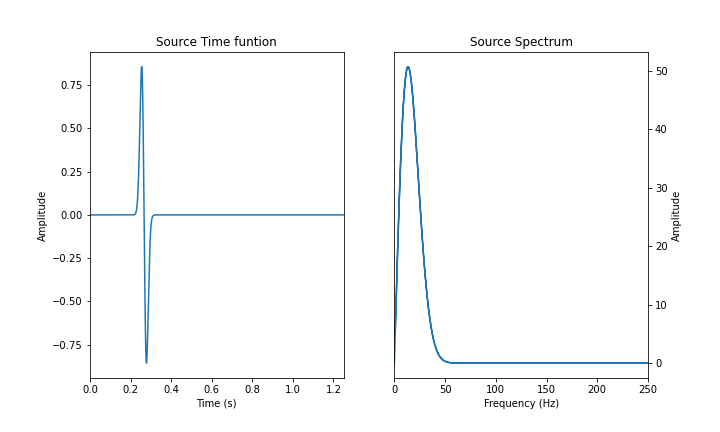

In [37]:
# -------------------------
# Plot source time funtion
# -------------------------

fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

# Source time funtion
ax1.plot(time, src)
ax1.set_title('Source Time funtion')
ax1.set_xlim(time[0], time[-1])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')

# Source spectrum
spec = np.fft.fft(src) # source time function in frequency domain
freq = np.fft.fftfreq(spec.size, d = dt ) # time domain to frequency domain
ax2.plot(np.abs(freq), np.abs(spec)) # plot frequency and amplitude
ax2.set_xlim(0, 250) # only display frequency from 0 to 250 Hz
ax2.set_title('Source Spectrum')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

plt.show()

<IPython.core.display.Javascript object>


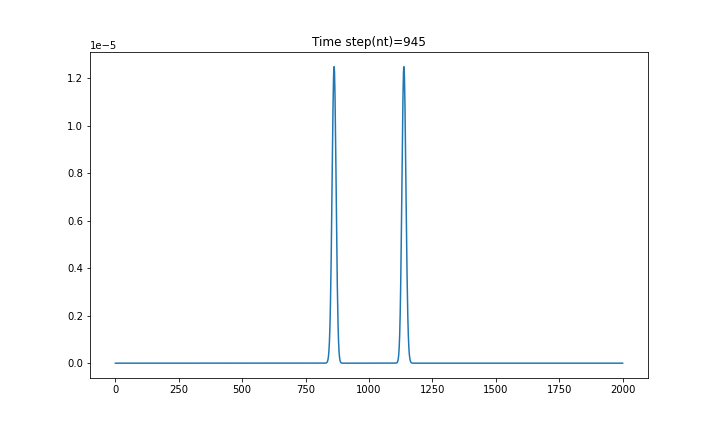

KeyboardInterrupt: 

In [82]:
# -----------------------------
# 1d acoustic wave propagation
# -----------------------------

# Initialize empty pressure
pnew = np.zeros(nptx)
p = np.zeros(nptx)
pold = np.zeros(nptx)
d2px = np.zeros(nptx)

x = np.arange(nptx) * dx

plt.ion()
fig2, ax3 = plt.subplots(figsize=(10, 6))
ax3.plot(sx, 0, 'r*') # Plot source position
ax3.set_title('Time step (n)')
ax3.set_xlim(x[0], x[-1])
ax3.set_xlabel('x (m)')
#ax3.set_ylim(-0.5e-5, 1.5e-5)
ax3.set_ylabel('Pressure Amplitude')
plt.show()

for n in range(nt + 1):
    for i in range(1, nx):
        d2px[i] = (p[i + 1] - 2 * p[i] + p[i - 1]) / dx ** 2
        
    pnew = 2 * p - pold + c0 ** 2 * dt ** 2 * d2px
    
    pnew[sx] = pnew[sx] + src[n] * dt ** 2
    
    pold, p = p, pnew
    
    if (n % 5 == 0):
        ax3.cla()
        ax3.set_title('Time step(nt)=%d' % n)
        ax3.plot(p)
        plt.gcf().canvas.draw()

<IPython.core.display.Javascript object>


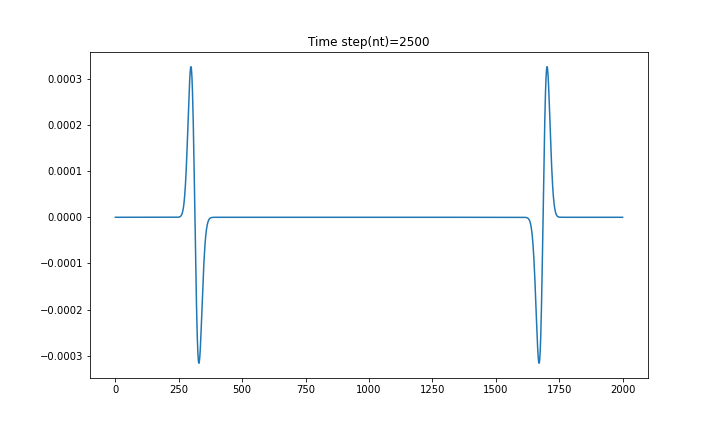

In [98]:
# ----------------------
# Stagerred-Grid
# -----------------------

# Initialize empty pressure and velocity
pnew = np.zeros(nptx)
p = np.zeros(nptx)
unew = np.zeros(nptx - 1)
u = np.zeros(nptx - 1)
dpx = np.zeros(u.shape)
dux = np.zeros(p.shape)

x = np.arange(nptx) * dx

plt.ion()
fig3, ax4 = plt.subplots(figsize=(10, 6))
ax4.plot(sx, 0, 'r*') # Plot source position
ax4.set_title('Time step (n)')
ax4.set_xlim(x[0], x[-1])
ax4.set_xlabel('x (m)')
ax4.set_ylabel('Pressure Amplitude')
plt.show()

for n in range(nt + 1):
    for i in range(nx):
        dpx[i] = (p[i + 1] - p[i]) / dx
    unew = u - (dt / rho) * dpx
    u = unew
    for i in range(1, nx):
        dux[i] = (u[i] - u[i-1]) / dx
    pnew = p - kapa * dt * dux
    pnew[sx] = pnew[sx] + src[n] * dt 
    
    p = pnew
    
    if (n % 5 == 0):
        ax4.cla()
        ax4.set_title('Time step(nt)=%d' % n)
        ax4.plot(p)
        plt.gcf().canvas.draw()

In [23]:
# -------------------------
# Perfectly Matched Layer
# -------------------------

# Only set PML in positive direction
nxp = int(nx/10) # Number of grids in each PML region
delta = nxp * dx # Width of each PML region
nxc = nx + nxp   # Number of grid in computational domain
nptxc = nxc + 1

# Dampling parameter
R = 0.001 # Reflection coefficient
sigma0 = np.log(1 / R) * 3 * c0 / (2 * delta)
def sigma(x):
    if x < xmax:
        return 0
    else:
        return sigma0 * (x - xmax) ** 2 / delta ** 2

In [32]:
xu = np.arange(nxc) * dx + (dx / 2)
xp = np.arange(nptxc) * dx
sigmau = np.array(list(map(sigma, xu)))
sigmap = np.array(list(map(sigma, xp)))

<IPython.core.display.Javascript object>


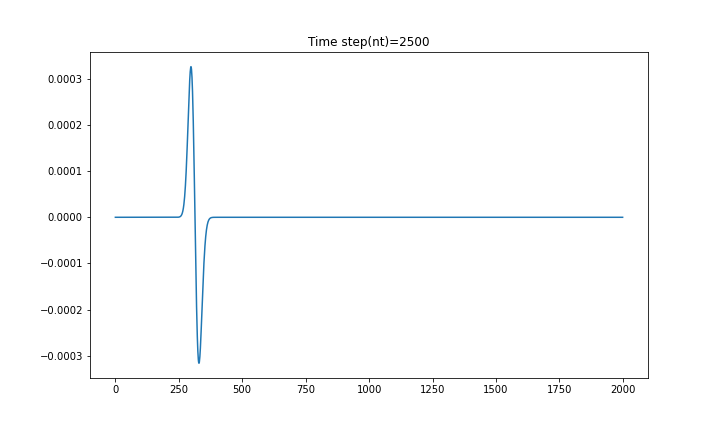

In [40]:
# Initialize empty pressure and velocity
pnew = np.zeros(nptxc)
p = np.zeros(nptxc)
unew = np.zeros(nptxc - 1)
u = np.zeros(nptxc - 1)
dpx = np.zeros(u.shape)
dux = np.zeros(p.shape)



plt.ion()
fig4, ax5 = plt.subplots(figsize=(10, 6))
ax5.plot(sx, 0, 'r*') # Plot source position
ax5.set_title('Time step (n)')
ax5.set_xlim(x[0], x[-1])
ax5.set_xlabel('x (m)')
ax5.set_ylabel('Pressure Amplitude')
plt.show()

for n in range(nt + 1):
    for i in range(nxc):
        dpx[i] = (p[i + 1] - p[i]) / dx
    unew = u - (dt / rho) * dpx - dt * sigmau * u
    u = unew
    for i in range(1, nxc):
        dux[i] = (u[i] - u[i-1]) / dx
    pnew = p - kapa * dt * dux - dt * sigmap * p
    pnew[sx] = pnew[sx] + src[n] * dt 
    
    p = pnew
    
    if (n % 5 == 0):
        ax5.cla()
        ax5.set_title('Time step(nt)=%d' % n)
        ax5.plot(p)
        plt.gcf().canvas.draw()